In [16]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as pl
from netCDF4 import Dataset
import open_xarray as ox

pl.rcParams['xtick.labelsize'] = 12
pl.rcParams['ytick.labelsize'] = 12
pl.rcParams['axes.labelsize'] = 16
pl.rcParams['axes.titlesize'] = 16
pl.rcParams['legend.fontsize'] = 12

ds=ox.open_xarray('/fs/ess/PFS0220/eurec4a/Case_Runs/Different_nc0/Feb2nd_1024_150m_8km_50.nc')
ds2=ox.open_xarray('/fs/ess/PFS0220/eurec4a/Case_Runs/Different_nc0/Feb2nd_1024_150m_8km_150.nc')
ds3=ox.open_xarray('/fs/ess/PFS0220/eurec4a/Case_Runs/Different_nc0/Feb2nd_1024_150m_8km_400.nc')
ds4=ox.open_xarray('/fs/ess/PFS0220/eurec4a/Case_Runs/Different_nc0/Feb2nd_1024_150m_8km_700.nc')
ds5=ox.open_xarray('/fs/ess/PFS0220/eurec4a/Case_Runs/Different_nc0/Feb2nd_1024_150m_jan31_8km_10/eurec4a.default.0000000.nc')
ds6=ox.open_xarray('/fs/ess/PFS0220/eurec4a/Case_Runs/Increased_SST/eurec4a.default.0000000.nc')
ds_smooth=ds.rolling(time=12).mean()
ds2_smooth=ds2.rolling(time=12).mean()
ds3_smooth=ds3.rolling(time=12).mean()
ds4_smooth=ds4.rolling(time=12).mean()
ds5_smooth=ds5.rolling(time=12).mean()
#ds6_smooth=ds6.rolling(time=12).mean()



label1=r'50 $cm^{-3}$'
label2=r'150 $cm^{-3}$'
label3=r'400 $cm^{-3}$'
label4=r'700 $cm^{-3}$'
label5=r'10 $cm^{-3}$'



/users/PFS0220/graghuna/.conda/envs/local/lib/python3.9/site-packages/xarray/core/duck_array_ops.py:213: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/users/PFS0220/graghuna/.conda/envs/local/lib/python3.9/site-packages/xarray/core/duck_array_ops.py:213: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/users/PFS0220/graghuna/.conda/envs/local/lib/python3.9/site-packages/xarray/core/duck_array_ops.py:213: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/users/PFS0220/graghuna/.conda/envs/local/lib/python3.9/site-packages/xarray/core/duck_array_ops.py:213: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/users/PFS0220/graghuna/.conda/envs/local/lib/python3.9/site-packages/xarray/core/duck_array_ops.py:213: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


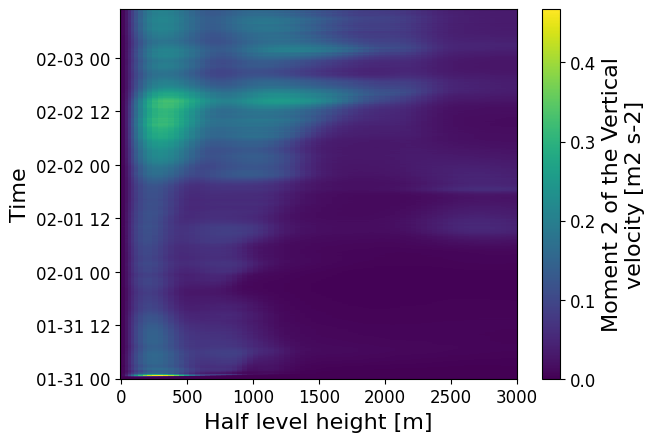

In [39]:
#ds5
ds5.w_2.sel(zh=slice(0,3000)).plot(label=label5)

In [15]:
#### Field Plots #####
import os
import numpy as np
import matplotlib.pyplot as pl
from matplotlib import cm
import math
from scipy.stats import norm
import seaborn as sns
import xarray as xr
import netCDF4 as nc
import sys

sys.setrecursionlimit(1000000)

##########################################################################################
class cell:
    def __init__(self, id):
        self.id = id
        self.value = [[],[]]
        self.location = [[],[]]
        self.nelements = 0
        self.nelements_local = 0

    def add_elements(self, i, j, var_values):
        self.location[0].append(i)
        self.location[1].append(j)
        self.value[0].append(var_values)
        self.nelements = self.nelements + 1
        self.nelements_local = self.nelements_local + 1
    def __del__(self):
        return
##########################################################################################
def find_boolean(variable, threshold_criteria): #variable is f(i, j, t): --> outputs boolean -1 (unsatisfied) 0 (satisfied) 
    boolean = np.zeros(( len(variable[:,0]), len(variable[0,:])))
    boolean = -1
    boolean = np.where(variable[:,:]>threshold_criteria,0,-1)
    return boolean;
########################################################################################
def identify_elements_in_cell(i,j,new_cell):  #input the ijk at which boolean is satisfied along with boolean and new cell created 

    global booli;
    new_cell.add_elements(i,j,cell_variable[i,j])
    booli[i,j] = -1

    ii=i-1; jj=j; #look west
    if ii<0:
       ii = nx-1
    if (booli[ii,jj] == 0):
        identify_elements_in_cell(ii,jj,new_cell)  

    ii=i+1; jj=j;  #look east
    if ii>nx-1:
       ii = 0
    if (booli[ii,jj] == 0):
        identify_elements_in_cell(ii,jj,new_cell)  

    ii=i; jj=j+1;  #look north
    if jj>ny-1:
        jj = 0
    if (booli[ii,jj] == 0):
        identify_elements_in_cell(ii,jj,new_cell)  

    ii=i; jj=j-1;  #look south
    if jj<0:
       jj = ny-1
    if (booli[ii,jj] == 0):
        identify_elements_in_cell(ii,jj,new_cell) 
#################################################################################################
def create_new_cell(variable,bool):                                # input the boolean and the variable, output is the cells tracked (i,j,t) based on boolean 
    cell_number = 0;
    global booli,cell_variable,nx,ny;
    nx = len(variable[:,0])
    ny = len(variable[0,:])
    booli=bool;cell_variable = variable;
    variable_cells = []
    for j in range(0,ny):
        for i in range(0,nx):
            if booli[i,j]==0: 
                new_cell=cell(cell_number) 
                identify_elements_in_cell(i,j,new_cell)
                if new_cell.nelements>=nminelems:
                    variable_cells.append(new_cell)
                    variable_cells[cell_number].id = cell_number
                    cell_number = cell_number + 1
                else:
                    del new_cell;
    return variable_cells, cell_number;
#################################################################################################
def run_tracking(tracked_variable,param_threshold):
    global nx,ny;
    nx = len(tracked_variable[:,0]); ny = len(tracked_variable[0,:]); 
    bool = find_boolean(tracked_variable,param_threshold)
    [cells,cell_number] = create_new_cell(tracked_variable,bool);
    return cells,cell_number;
####################################################################################################
def find_cell_centers(cells,ncells):
    centers=np.zeros((ncells,2))
    max_cloudsize=0;
    for i in range(0,ncells):
        centers[i,0]=np.mean(cells[i].location[0])
        centers[i,1]=np.mean(cells[i].location[1])
        if cells[i].nelements>max_cloudsize:
            max_cloudsize=cells[i].nelements
    return centers,max_cloudsize;
####################################################################################################
def find_nearest_neighbor(centers,nx,ny):
    distance=np.zeros(len(centers[:,0]))
    nn_distance=np.zeros(len(centers[:,0]))
    for i in range(len(centers[:,0])):
        for j in range(len(centers[:,0])):
            if i==j:
                distance[j]=100;
            else:
                xdist=min(abs(centers[i,0]+nx-centers[j,0]),abs(centers[i,0]-nx-centers[j,0]),abs(centers[i,0]-centers[j,0]))
                ydist=min(abs(centers[i,1]+ny-centers[j,1]),abs(centers[i,1]-ny-centers[j,1]),abs(centers[i,1]-centers[j,1]))
                distance[j]=math.sqrt(xdist**2+ydist**2)
        nn_distance[i]=min(distance)
    return nn_distance;
####################################################################################################
def retrieve_variable(variable_name,netcdf_path): #open corresponding netcdf file and read data
    all_data=xr.open_dataset(netcdf_path,decode_times=False)
    var=all_data[variable_name].values
    variable=var
    x=all_data['x'].values
    y=all_data['y'].values
    t=all_data['time'].values
    return variable, x, y, t;    
##########################################################################################
#[w_cross,x,y,t]=retrieve_variable(variable_name='w',netcdf_path='/fs/ess/PFS0220/eurec4a/case_1060lagtraj_feb2_withw/w_cross.nc')
def get_iorg(xr_data,variable_name,param_threshold,start_ind,slice_len):
    variable=xr_data[variable_name].values
    i_org=np.zeros(xr_data.time.size)
    Max_Clouds=np.zeros(xr_data.time.size)
    for i in range(start_ind,xr_data.time.size,slice_len):
        if i%60==0:
            print(i)
        [clouds,ncells]=run_tracking(tracked_variable=variable[i,:,:],param_threshold=param_threshold)
        if ncells<2:
            i_org[i]=0;
            Max_Clouds[i]=0;
        else:
            [centers,Max_Clouds[i]]=find_cell_centers(clouds,ncells)
            nn_distance=find_nearest_neighbor(centers,nx,ny)
            centers=centers.astype(int)
            nn_sorted = np.sort(nn_distance);nn_sorted=nn_sorted/max(nn_sorted)
            p = 1. * np.arange(len(nn_distance)) / (len(nn_distance) - 1)
            p_ran=1-np.exp(-1*(math.pi)*nn_sorted*nn_sorted)
            i_org[i]=np.trapz(p,x=p_ran)
    xr_data['i_org']=xr.DataArray(i_org,dims=['time'])
    xr_data['Max_Clouds']=xr.DataArray(Max_Clouds,dims=['time'])
    return xr_data;
#########################################################################################

nminelems=100
start_hr=48
slice_len=12;


nc_path='/fs/ess/PFS0220/eurec4a/Case_Runs/Different_nc0/Feb2nd_1024_150m_jan31_8km_10/ql_path.xy.nc'
ds_10=xr.open_dataset('/fs/ess/PFS0220/eurec4a/Case_Runs/Different_nc0/Feb2nd_1024_150m_jan31_8km_10/ql_path.xy.nc',decode_times=False)
ds_50=xr.open_dataset('/fs/ess/PFS0220/eurec4a/Case_Runs/Different_nc0/Feb2nd_1024_150m_jan31_8km_50/ql_path.xy.nc',decode_times=False)
ds_150=xr.open_dataset('/fs/ess/PFS0220/eurec4a/Case_Runs/Different_nc0/Feb2nd_1024_150m_jan31_8km_150/ql_path.xy.nc',decode_times=False)
ds_400=xr.open_dataset('/fs/ess/PFS0220/eurec4a/Case_Runs/Different_nc0/Feb2nd_1024_150m_jan31_8km_400/ql_path.xy.nc',decode_times=False)
ds_700=xr.open_dataset('/fs/ess/PFS0220/eurec4a/Case_Runs/Different_nc0/Feb2nd_1024_150m_jan31_8km_700/ql_path.xy.nc',decode_times=False)

ds_10['time'].attrs['units'] = 's since 2020-01-31 00:00:00';ds_10['time'].attrs['calendar'] = 'proleptic_gregorian';ds_10['time'].attrs['axis'] = 'T'; 
ds_10=xr.decode_cf(ds_10);
ds_50['time'].attrs['units'] = 's since 2020-01-31 00:00:00';ds_50['time'].attrs['calendar'] = 'proleptic_gregorian';ds_50['time'].attrs['axis'] = 'T';
ds_50=xr.decode_cf(ds_50);
ds_150['time'].attrs['units'] = 's since 2020-01-31 00:00:00';ds_150['time'].attrs['calendar'] = 'proleptic_gregorian';ds_150['time'].attrs['axis'] = 'T';
ds_150=xr.decode_cf(ds_150);
ds_400['time'].attrs['units'] = 's since 2020-01-31 00:00:00';ds_400['time'].attrs['calendar'] = 'proleptic_gregorian';ds_400['time'].attrs['axis'] = 'T';
ds_400=xr.decode_cf(ds_400);
ds_700['time'].attrs['units'] = 's since 2020-01-31 00:00:00';ds_700['time'].attrs['calendar'] = 'proleptic_gregorian';ds_700['time'].attrs['axis'] = 'T';
ds_700=xr.decode_cf(ds_700);



ds_10=get_iorg(ds_10,'ql_path',0.01,start_ind=int(start_hr*3600/300),slice_len=slice_len)
ds_50=get_iorg(ds_50,'ql_path',0.01,start_ind=int(start_hr*3600/300),slice_len=slice_len)
ds_150=get_iorg(ds_150,'ql_path',0.01,start_ind=int(start_hr*3600/300),slice_len=slice_len)
ds_400=get_iorg(ds_400,'ql_path',0.01,start_ind=int(start_hr*3600/300),slice_len=slice_len)
ds_700=get_iorg(ds_700,'ql_path',0.01,start_ind=int(start_hr*3600/300),slice_len=slice_len)



600
660
720
780
840
900
960
600
660
720
780
840
900
960
600
660
720
780
840
900
960
600
660
720
780
840
900
960
600
660
720
780
840
900
960


Text(0.05, 0.28, 'd)')

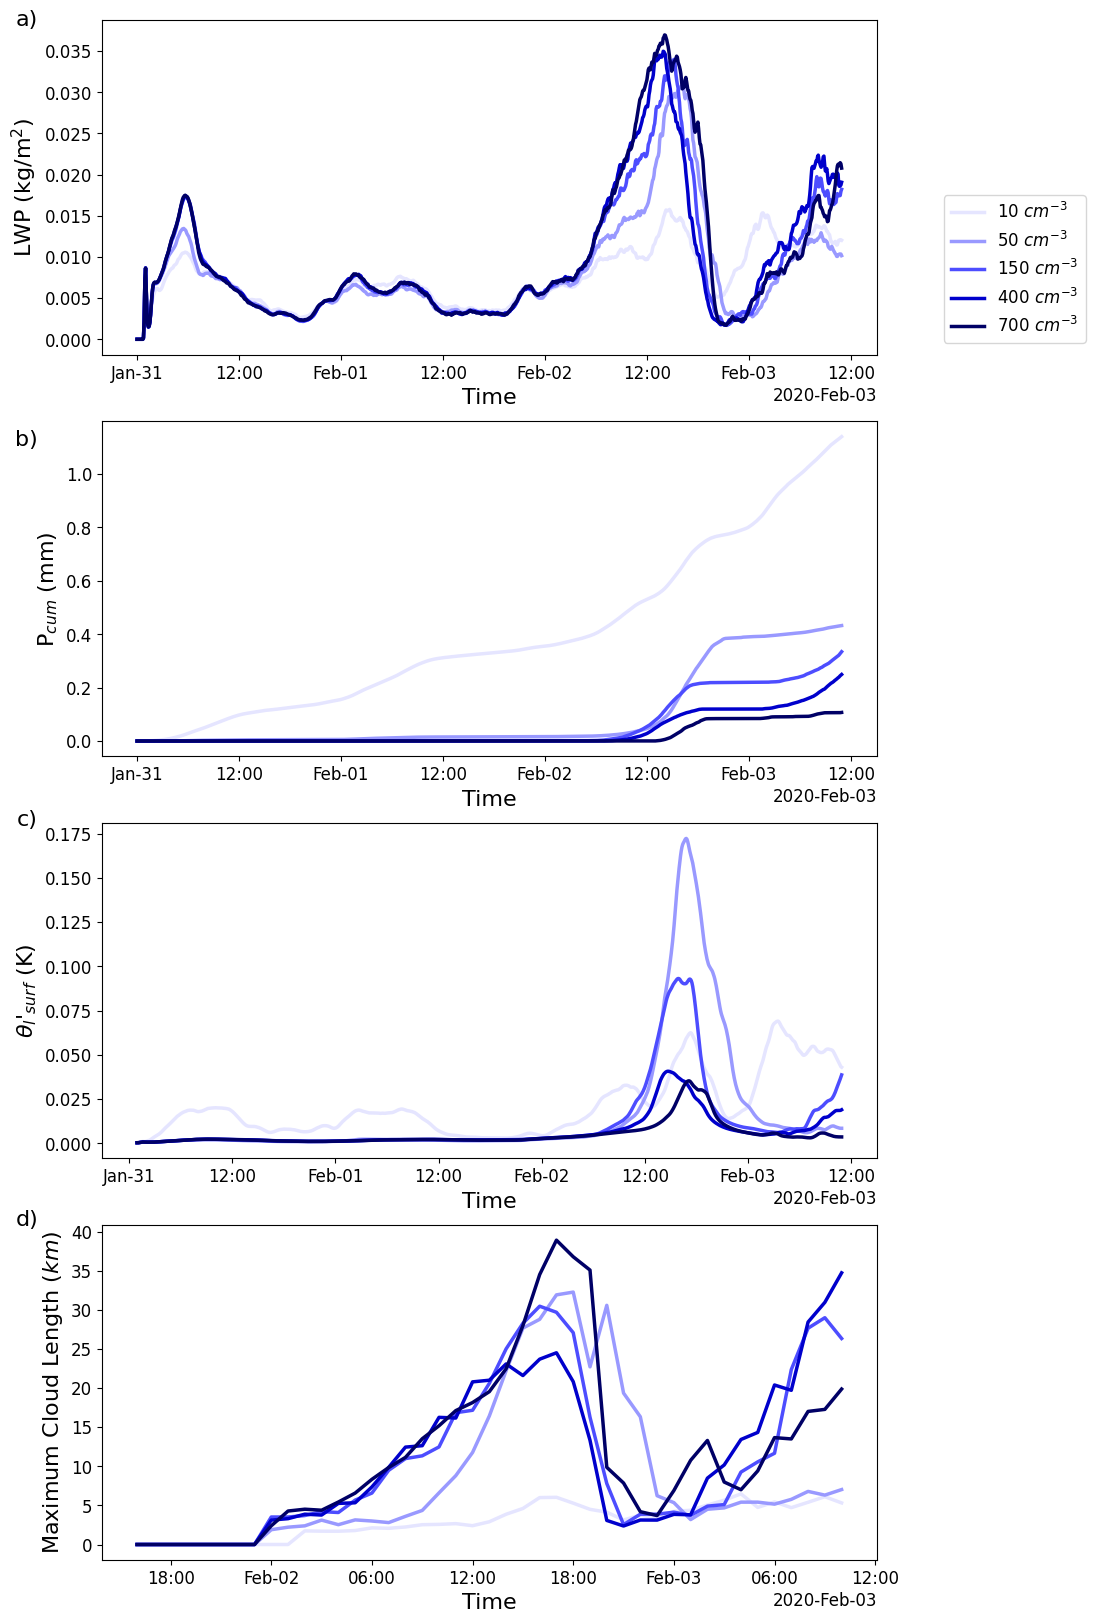

In [14]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])


fig, axs = pl.subplots(4, 1, figsize=(10, 20))
pl.subplot(411)
ds5.ql_path.plot.line(color=lighten_color('b',0.1),lw=2.5,x='time',label=label5)
ds.ql_path.plot.line(color=lighten_color('b',0.4),lw=2.5,x='time',label=label1)
ds2.ql_path.plot.line(color=lighten_color('b',0.7),lw=2.5,x='time',label=label2)
ds3.ql_path.plot.line(color=lighten_color('b',1.2),lw=2.5,x='time',label=label3)
ds4.ql_path.plot.line(color=lighten_color('b',1.6),lw=2.5,x='time',label=label4)
pl.ylabel(r'LWP (kg/m$^{2}$)')
#pl.xticks([])
#pl.xlabel('')
#pl.show()

pl.subplot(412)
(ds5['rr']*300).cumsum().plot.line(color=lighten_color('b',0.1),lw=2.5,x='time',label=label5)
(ds['rr']*300).cumsum().plot.line(color=lighten_color('b',0.4),lw=2.5,x='time',label=label1)
(ds2['rr']*300).cumsum().plot.line(color=lighten_color('b',0.7),lw=2.5,x='time',label=label2)
(ds3['rr']*300).cumsum().plot.line(color=lighten_color('b',1.2),lw=2.5,x='time',label=label3)
(ds4['rr']*300).cumsum().plot.line(color=lighten_color('b',1.6),lw=2.5,x='time',label=label4)
pl.ylabel(r'P$_{cum}$ (mm)')
#pl.show()
#pl.xticks([])
#pl.xlabel('')

pl.subplot(413)
ds5_smooth.thl_2.isel(z=0).plot.line(color=lighten_color('b',0.1),lw=2.5,x='time',label=label5)
ds_smooth.thl_2.isel(z=0).plot.line(color=lighten_color('b',0.4),lw=2.5,x='time',label=label1)
ds2_smooth.thl_2.isel(z=0).plot.line(color=lighten_color('b',0.7),lw=2.5,x='time',label=label2)
ds3_smooth.thl_2.isel(z=0).plot.line(color=lighten_color('b',1.2),lw=2.5,x='time',label=label3)
ds4_smooth.thl_2.isel(z=0).plot.line(color=lighten_color('b',1.6),lw=2.5,x='time',label=label4)
pl.ylabel(r"$\theta_l$'$_{surf}$ (K)")
pl.title('')

pl.subplot(414)
(ds_10.Max_Clouds**(1/2)*0.15).isel(time=slice(40*12,None,slice_len)).plot.line(color=lighten_color('b',0.1),lw=2.5,label=label5)
(ds_50.Max_Clouds**(1/2)*0.15).isel(time=slice(40*12,None,slice_len)).plot.line(color=lighten_color('b',0.4),lw=2.5,label=label1)   
(ds_150.Max_Clouds**(1/2)*0.15).isel(time=slice(40*12,None,slice_len)).plot.line(color=lighten_color('b',0.7),lw=2.5,label=label2)
(ds_400.Max_Clouds**(1/2)*0.15).isel(time=slice(40*12,None,slice_len)).plot.line(color=lighten_color('b',1.2),lw=2.5,label=label3)  
(ds_700.Max_Clouds**(1/2)*0.15).isel(time=slice(40*12,None,slice_len)).plot.line(color=lighten_color('b',1.6),lw=2.5,label=label4)
pl.xlabel('Time')
pl.ylabel(r'Maximum Cloud Length $(km)$')

pl.legend(bbox_to_anchor=(1.28, 4.1))
pl.figtext(0.05, 0.88, 'a)', ha='center', va='center', fontsize=16)
pl.figtext(0.05, 0.67, 'b)', ha='center', va='center', fontsize=16)
pl.figtext(0.05, 0.48, 'c)', ha='center', va='center', fontsize=16)
pl.figtext(0.05, 0.28, 'd)', ha='center', va='center', fontsize=16)

#pl.savefig('/users/PFS0220/graghuna/Flower_MIP_Paper/Plots/CDNC_Feb2nd.jpg',dpi=300, bbox_inches='tight')

/tmp/ipykernel_2977598/1934917523.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  time[i] = (output[key]['time'].where(output[key][variable]==output[key][variable].isel(time=slice(None,time_end)).max(),drop=True)-output[key]['time'][0]).dt.seconds.values / 3600
/tmp/ipykernel_2977598/1934917523.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  time[i] = (output[key]['time'].where(output[key][variable]==output[key][variable].isel(time=slice(None,time_end)).max(),drop=True)-output[key]['time'][0]).dt.seconds.values / 3600
/tmp/ipykernel_2977598/1934917523.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is

0.03629402816295624 1.573870758875273e-05 0.17223532497882843 67270.0


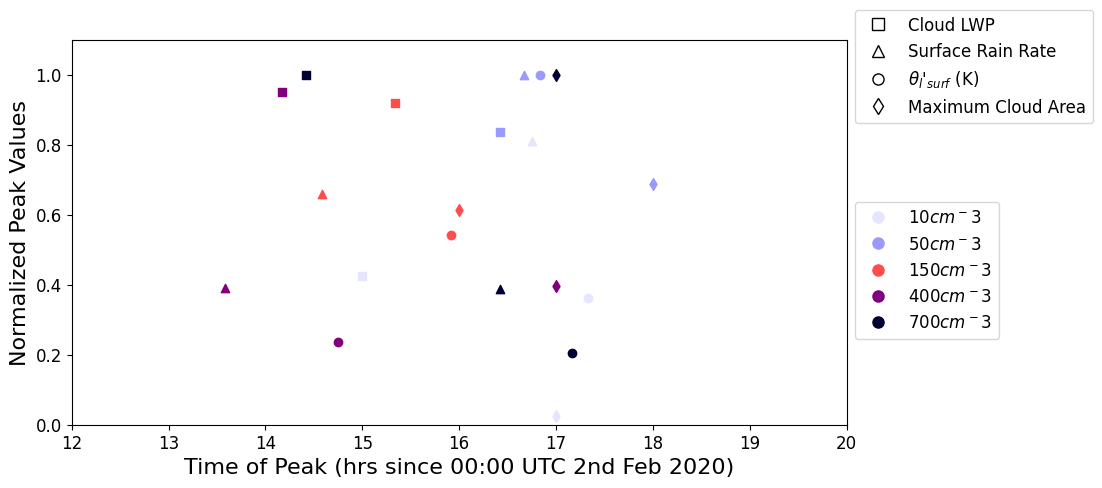

In [33]:
from matplotlib import lines as mlines
output = {'5':ds5,'1':ds,'2':ds2,'3':ds3,'4':ds4}
output={'5':ds5_smooth,'1':ds_smooth,'2':ds2_smooth,'3':ds3_smooth,'4':ds4_smooth}
output_cloud = {'1':ds_10,'2':ds_50,'3':ds_150,'4':ds_400,'5':ds_700}
nc0=[r'10$cm^-3$',r'50$cm^-3$',r'150$cm^-3$',r'400$cm^-3$',r'700$cm^-3$']

def find_max(output,variable,time_end):
    time = np.zeros(5)
    peak_val = np.zeros(5)
    i=0
    for key in output:
        if variable=='thl_2':
            time[i] = (output[key]['time'].where(output[key][variable].isel(z=0)==output[key][variable].isel(z=0,time=slice(None,time_end)).max(),drop=True)-output[key]['time'][0]).dt.seconds.values / 3600
            peak_val[i] = output[key][variable].isel(z=0,time=slice(None,time_end)).max().values
            i=i+1
        else:
            time[i] = (output[key]['time'].where(output[key][variable]==output[key][variable].isel(time=slice(None,time_end)).max(),drop=True)-output[key]['time'][0]).dt.seconds.values / 3600
            peak_val[i] = output[key][variable].isel(time=slice(None,time_end)).max().values
        #time[i+len(nc0)] = (output[key]['time'].where(output[key]['ql_path']==output[key]['ql_path'].isel(time=slice(int(72*3600/300),None)).max(),drop=True)\
        #                    -output[key]['time'][0]).dt.seconds.values + 86400 
        #peak_ql[i+len(nc0)] = output[key]['ql_path'].isel(time=slice(int(72*3600/300),None)).max().values
            i=i+1
    return time,peak_val;

markers=['s','o','^','*','d']
colors=[lighten_color('b',0.1),lighten_color('b',0.4),lighten_color('r',0.7),lighten_color('m',1.2),lighten_color('b',1.8)]
fig,ax = pl.subplots(figsize=(10,5))
time_ql,peak_ql=find_max(output,'ql_path',72*12)
time_rr,peak_rr=find_max(output,'rr',72*12)
time_thl,peak_thl=find_max(output,'thl_2',72*12)
time_maxql,peak_maxql=find_max(output_cloud,'Max_Clouds',72*12)
line = [0,0,0,0,0]
for i in range(5):
    ax.scatter(time_ql[i],peak_ql[i]/peak_ql.max(),marker='s',color=colors[i])
    ax.scatter(time_rr[i],peak_rr[i]/peak_rr.max(),marker='^',color=colors[i])
    ax.scatter(time_thl[i],peak_thl[i]/peak_thl.max(),marker='o',color=colors[i])
    ax.scatter(time_maxql[i],peak_maxql[i]/peak_maxql.max(),marker='d',color=colors[i])
    line[i] = mlines.Line2D([], [], color=colors[i], marker='o',markersize=8,linestyle='None',label=nc0[i])
legend1= pl.legend(handles=[line[0],line[1],line[2],line[3],line[4]],loc='upper left',bbox_to_anchor=(1, 0.6))
ax = pl.gca().add_artist(legend1)
line2 = mlines.Line2D([], [], color='k', marker='s',markersize=8,markerfacecolor='None',linestyle='None',label='Cloud LWP')
line3 = mlines.Line2D([], [], color='k', marker='^',markersize=8,markerfacecolor='None',linestyle='None',label='Surface Rain Rate')
line4 = mlines.Line2D([], [], color='k', marker='o',markersize=8,markerfacecolor='None',linestyle='None',label=r"$\theta_l$'$_{surf}$ (K)")
line5 = mlines.Line2D([], [], color='k', marker='d',markersize=8,markerfacecolor='None',linestyle='None',label='Maximum Cloud Area')
pl.legend(handles=[line2,line3,line4,line5],loc='upper left',bbox_to_anchor=(1, 1.1))
pl.xlim(12,20)
pl.ylim(0,1.1)
pl.ylabel('Normalized Peak Values')
pl.xlabel('Time of Peak (hrs since 00:00 UTC 2nd Feb 2020)')

print(peak_ql.max(),peak_rr.max(),peak_thl.max(),peak_maxql.max())
pl.savefig('/users/PFS0220/graghuna/Flower_MIP_Paper/Plots/Normalized_Peak_Values_Feb2nd_nc0.jpg',dpi=300, bbox_inches='tight')

In [19]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as pl
from netCDF4 import Dataset
import open_xarray as ox

pl.rcParams['xtick.labelsize'] = 12
pl.rcParams['ytick.labelsize'] = 12
pl.rcParams['axes.labelsize'] = 16
pl.rcParams['axes.titlesize'] = 16
pl.rcParams['legend.fontsize'] = 12

ds=ox.open_xarray('/fs/ess/PFS0220/eurec4a/Case_Runs/Different_nc0/Feb9_1024_150m_8km_10/eurec4a.default.0000000.nc')
ds2=ox.open_xarray('/fs/ess/PFS0220/eurec4a/Case_Runs/Different_nc0/Feb9_1024_150m_8km_50/eurec4a.default.0000000.nc')
ds3=ox.open_xarray('/fs/ess/PFS0220/eurec4a/Case_Runs/Different_nc0/Feb9_1024_150m_8km_150/eurec4a.default.0000000.nc')
ds4=ox.open_xarray('/fs/ess/PFS0220/eurec4a/Case_Runs/Different_nc0/Feb9_1024_150m_8km_400/eurec4a.default.0000000.nc')
ds5=ox.open_xarray('/fs/ess/PFS0220/eurec4a/Case_Runs/Different_nc0/Feb9_1024_150m_8km_700/eurec4a.default.0000000.nc')
ds_smooth=ds.rolling(time=12).mean()
ds2_smooth=ds2.rolling(time=12).mean()
ds3_smooth=ds3.rolling(time=12).mean()
ds4_smooth=ds4.rolling(time=12).mean()
ds5_smooth=ds5.rolling(time=12).mean()
ds6_smooth=ds6.rolling(time=12).mean()


label1='10e6'
label2='50e6'
label3='150e6'
label4='400e6'
label5='700e6'






/users/PFS0220/graghuna/.conda/envs/local/lib/python3.9/site-packages/xarray/core/duck_array_ops.py:213: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/users/PFS0220/graghuna/.conda/envs/local/lib/python3.9/site-packages/xarray/core/duck_array_ops.py:213: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/users/PFS0220/graghuna/.conda/envs/local/lib/python3.9/site-packages/xarray/core/duck_array_ops.py:213: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/users/PFS0220/graghuna/.conda/envs/local/lib/python3.9/site-packages/xarray/core/duck_array_ops.py:213: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/users/PFS0220/graghuna/.conda/envs/local/lib/python3.9/site-packages/xarray/core/duck_array_ops.py:213: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/users/PFS0220/graghuna/.conda/envs

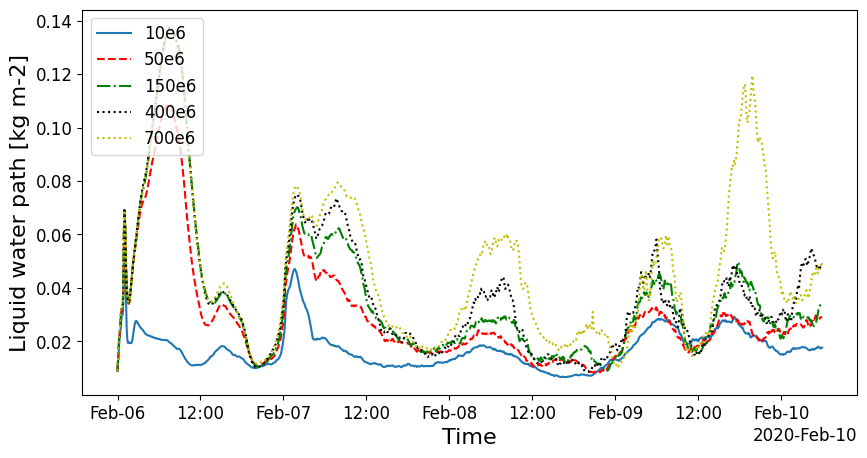

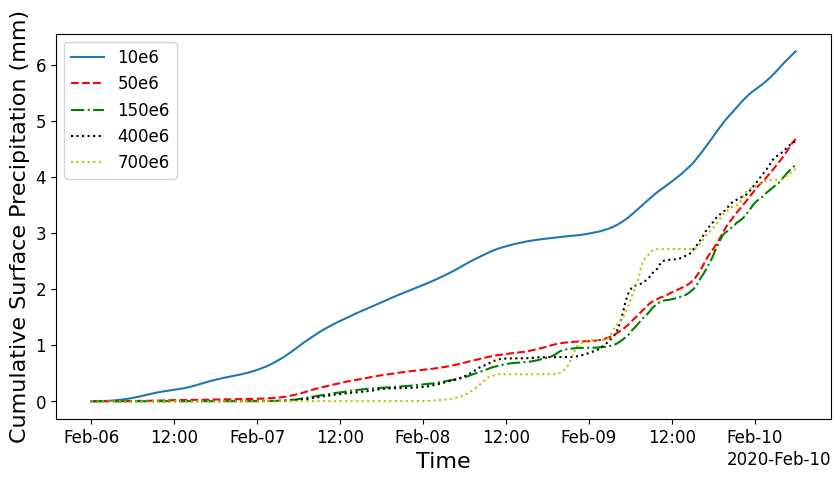

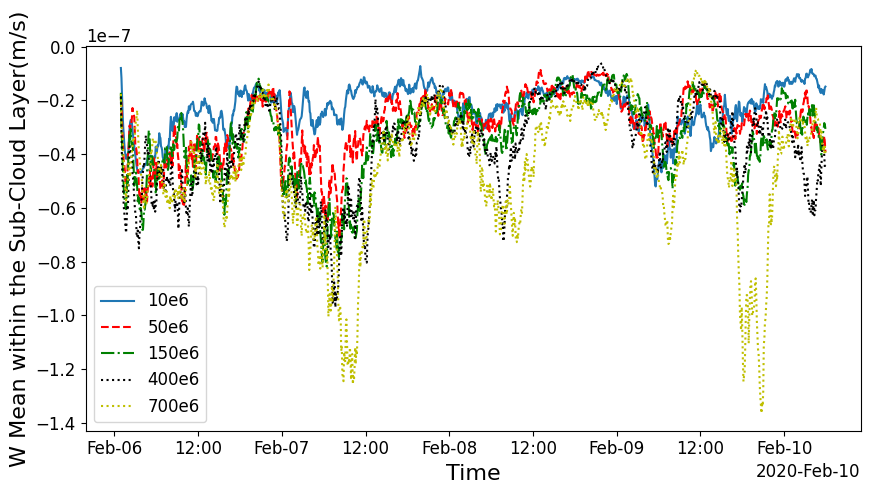

In [20]:
pl.figure(figsize=(10,5))
ds.ql_path.plot.line(x='time',label=label1)
ds2.ql_path.plot.line('r--',x='time',label=label2)
ds3.ql_path.plot.line('g-.',x='time',label=label3)
ds4.ql_path.plot.line('k:',x='time',label=label4)
ds5.ql_path.plot.line('y:',x='time',label=label5)
#pl.ylim(-0.005,0.13)
pl.legend(loc='upper left')

pl.figure(figsize=(10,5))

(ds['rr']*300).cumsum().plot.line(x='time',label=label1)
(ds2['rr']*300).cumsum().plot.line('r--',x='time',label=label2)
(ds3['rr']*300).cumsum().plot.line('g-.',x='time',label=label3)
(ds4['rr']*300).cumsum().plot.line('k:',x='time',label=label4)
(ds5['rr']*300).cumsum().plot.line('y:',x='time',label=label5)
#pl.ylim(-0.005,0.13)
pl.ylabel('Cumulative Surface Precipitation (mm)')
pl.legend()
pl.savefig('/users/PFS0220/graghuna/Flower_MIP_Paper/Plots/Cloud_droplet_number_concentration_cumRR.jpg',dpi=300)
#pl.yscale('log')

pl.figure(figsize=(10,5))

ds_smooth.sel(z=slice(0,600)).w.mean('zh').plot.line(x='time',label=label1)
ds2_smooth.sel(z=slice(0,600)).w.mean('zh').plot.line('r--',x='time',label=label2)
ds3_smooth.sel(z=slice(0,600)).w.mean('zh').plot.line('g-.',x='time',label=label3)
ds4_smooth.sel(z=slice(0,600)).w.mean('zh').plot.line('k:',x='time',label=label4)
ds5_smooth.sel(z=slice(0,600)).w.mean('zh').plot.line('y:',x='time',label=label5)
pl.legend()
pl.ylabel('W Mean within the Sub-Cloud Layer(m/s)')
pl.savefig('/users/PFS0220/graghuna/Flower_MIP_Paper/Plots/Cloud_droplet_number_concentration_wsum.jpg',dpi=300)
def powspace(start, stop, power, num):
    start = np.power(start, 1/float(power))
    stop = np.power(stop, 1/float(power))
    return np.power( np.linspace(start, stop, num=num), power)
#pl.figure(figsize=(10,5))
#ds5.ql.plot.contourf(x='time',levels=powspace(1e-7,7e-4,2,10))

def powspace(start, stop, power, num):
    start = np.power(start, 1/float(power))
    stop = np.power(stop, 1/float(power))
    return np.power( np.linspace(start, stop, num=num), power)

pl.figure(figsize=(10,5))
ds4.ql_frac.plot.contourf(x='time',levels=powspace(0,0.3,2,10))
pl.figure(figsize=(10,5))
(ds4['ql_frac']>0.01).plot.contourf(x='time')